In [1]:
import os
import re
import shutil
import sys
from datetime import date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import savgol_filter
import pyabf

from utils import *
from deconv import *

In [2]:
%matplotlib notebook
plt.rcParams.update({"figure.max_open_warning": 0})

In [3]:
data_path = "/mnt/Data/hanson_sac_velocity/June4_21_C1/"
base_abf_name = "210604_0"
ex_abf = pyabf.ABF(os.path.join(data_path, base_abf_name + "107.abf"))
print(ex_abf)

ABF (v2.6) with 2 channels (pA, pA), sampled at 10.0 kHz, containing 3 sweeps, having no tags, with a total length of 0.47 minutes, recorded with protocol "noPulse".


In [4]:
stim_info = pd.read_excel(os.path.join(data_path, "stim_info.xlsx"), index_col=0, skiprows=1)
stim_info

,Velocity,Holding
File #,,
107,5000,-60
108,4000,-60
109,3000,-60
110,2000,-60
111,1000,-60
112,500,-60
113,300,-60
114,100,-60
115,100,0


In [5]:
epsc_vels = stim_info.query("Holding == -60").filter(["Velocity"], axis="columns")
epsc_vels = epsc_vels.query("index >= 107 and index <= 114").sort_values(by="Velocity") 

ipsc_vels = stim_info.query("Holding == 0").filter(["Velocity"], axis="columns")
ipsc_vels = ipsc_vels.query("index >= 115 and index <= 122").sort_values(by="Velocity")

In [6]:
epsc_vels

,Velocity
File #,
114,100
113,300
112,500
111,1000
110,2000
109,3000
108,4000
107,5000


In [7]:
ipsc_vels

,Velocity
File #,
115,100
116,300
117,500
118,1000
119,2000
120,3000
121,4000
122,5000


<IPython.core.display.Javascript object>


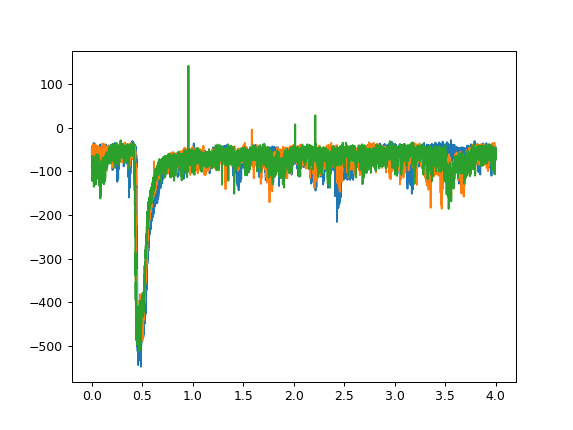

In [8]:
ex_fig, ex_ax = plt.subplots(1)
for i in range(3):
    ex_abf.setSweep(i)
    plt.plot(ex_abf.sweepX, ex_abf.sweepY)

In [9]:
def load_vel_recs(table):
    xaxes = {}
    recs = {}
    for num, row in table.iterrows():
        vel = row["Velocity"]
        abf = pyabf.ABF(os.path.join(data_path, "%s%i.abf" % (base_abf_name, num)))
        
        ys = []
        for i in abf.sweepList:
            abf.setSweep(i)
            ys.append(np.array(abf.sweepY))
            
        xaxes[vel] = np.array(abf.sweepX)
        recs[vel] = np.stack(ys, axis=0)
        
    return xaxes, recs

epsc_xaxes, epsc_recs = load_vel_recs(epsc_vels) 
ipsc_xaxes, ipsc_recs = load_vel_recs(ipsc_vels) 
dt = epsc_xaxes[1000][1] - epsc_xaxes[1000][0]

In [10]:
# vel_fig, vel_ax = plt.subplots(len(epsc_xaxes), sharex=True, figsize=(8, 12))
# for ax, vel in zip(vel_ax, epsc_xaxes.keys()):
#     ax.plot(epsc_xaxes[vel], epsc_recs[vel].mean(axis=0)) 
#     ax.plot(ipsc_xaxes[vel], ipsc_recs[vel].mean(axis=0)) 
#     ax.set_ylabel("%i μm/s" % vel)
    
# vel_ax[-1].set_xlabel("Time (s)")

<IPython.core.display.Javascript object>


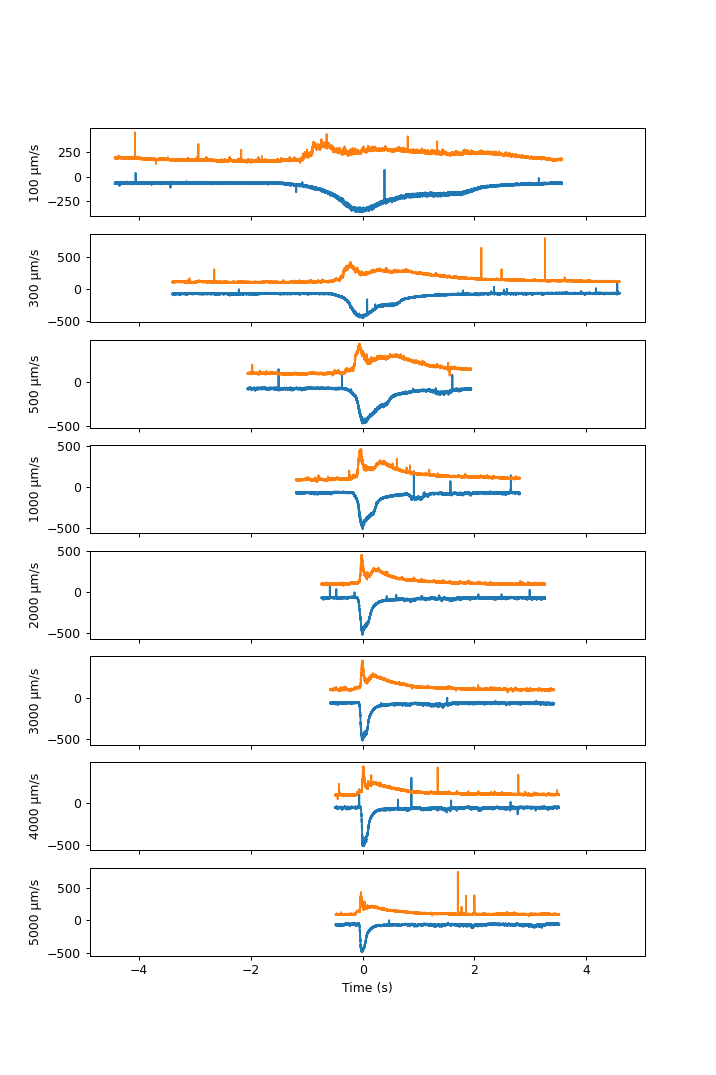

Text(0.5, 0, 'Time (s)')

In [11]:
aligned_vel_fig, aligned_vel_ax = plt.subplots(len(epsc_xaxes), sharex=True, figsize=(8, 12))
for ax, vel in zip(aligned_vel_ax, epsc_xaxes.keys()):
    ec = epsc_recs[vel].mean(axis=0)
    ic = ipsc_recs[vel].mean(axis=0)
    t = epsc_xaxes[vel][ec.argmin()]
    
    ax.plot(epsc_xaxes[vel] - t, ec) 
    ax.plot(ipsc_xaxes[vel] - t, ic) 
    ax.set_ylabel("%i μm/s" % vel)
    
aligned_vel_ax[-1].set_xlabel("Time (s)")

<IPython.core.display.Javascript object>


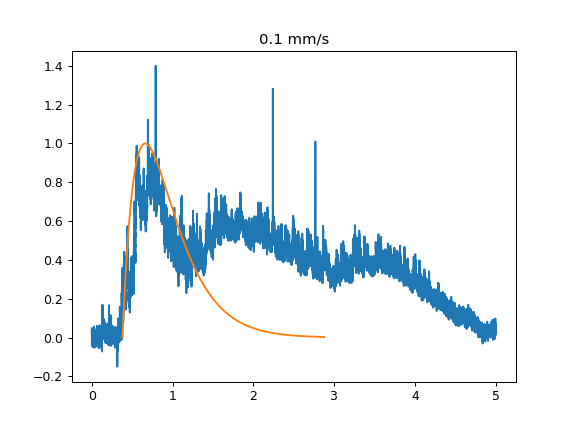

Text(0.5, 1.0, '0.1 mm/s')

In [12]:
start = nearest_index(ipsc_xaxes[100], 3)
crop_ipsc_100 = peak_normalize(np.mean(ipsc_recs[100], axis=0)[start:], bsln_end=100)
crop_ipsc_100_ax = np.arange(len(crop_ipsc_100)) * (ipsc_xaxes[100][1] - ipsc_xaxes[100][0])

i100_alpha_xaxis, i100_alpha = make_biexp(2500, 0.001, tau1=0.28, tau2=0.281)
i100_fig, i100_ax = plt.subplots(1)
i100_ax.plot(crop_ipsc_100_ax, crop_ipsc_100 * 1.4)
i100_ax.plot(i100_alpha_xaxis + 0.38, i100_alpha)
i100_ax.set_title("0.1 mm/s")

<IPython.core.display.Javascript object>


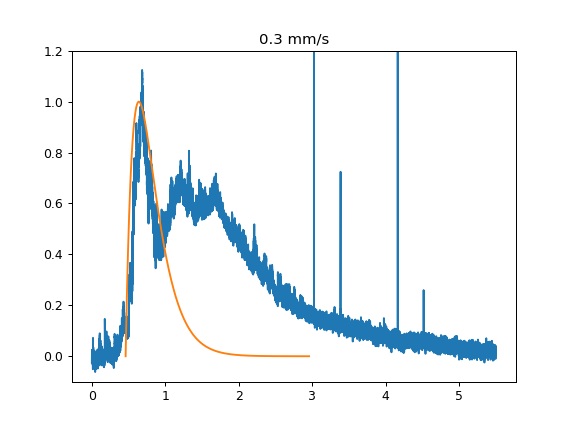

Text(0.5, 1.0, '0.3 mm/s')

In [13]:
start = nearest_index(ipsc_xaxes[300], 2.5)
crop_ipsc_300 = peak_normalize(np.mean(ipsc_recs[300], axis=0)[start:], bsln_end=100)
crop_ipsc_300_ax = np.arange(len(crop_ipsc_300)) * (ipsc_xaxes[300][1] - ipsc_xaxes[300][0])

i300_alpha_xaxis, i300_alpha = make_biexp(2500, 0.001, tau1=0.18, tau2=0.181)
i300_fig, i300_ax = plt.subplots(1)
i300_ax.plot(crop_ipsc_300_ax, crop_ipsc_300 * 2.5)
i300_ax.plot(i300_alpha_xaxis + 0.46, i300_alpha)
i300_ax.set_ylim(-0.1, 1.2)
i300_ax.set_title("0.3 mm/s")

<IPython.core.display.Javascript object>


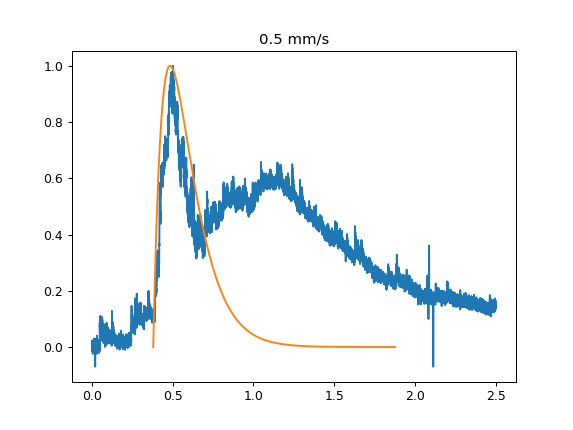

Text(0.5, 1.0, '0.5 mm/s')

In [14]:
start = nearest_index(ipsc_xaxes[500], 1.5)
crop_ipsc_500 = peak_normalize(np.mean(ipsc_recs[500], axis=0)[start:], bsln_end=100)
crop_ipsc_500_ax = np.arange(len(crop_ipsc_500)) * (ipsc_xaxes[500][1] - ipsc_xaxes[500][0])

i500_alpha_xaxis, i500_alpha = make_biexp(1500, 0.001, tau1=0.1, tau2=0.11)
i500_fig, i500_ax = plt.subplots(1)
i500_ax.plot(crop_ipsc_500_ax, crop_ipsc_500)
i500_ax.plot(i500_alpha_xaxis + 0.38, i500_alpha)
i500_ax.set_title("0.5 mm/s")

<IPython.core.display.Javascript object>


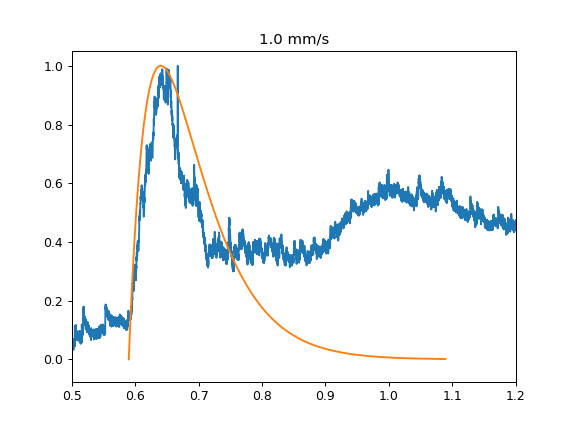

Text(0.5, 1.0, '1.0 mm/s')

In [15]:
start = nearest_index(ipsc_xaxes[1000], 0.5)
crop_ipsc_1000 = peak_normalize(np.mean(ipsc_recs[1000], axis=0)[start:], bsln_end=100)
crop_ipsc_1000_ax = np.arange(len(crop_ipsc_1000)) * (ipsc_xaxes[1000][1] - ipsc_xaxes[1000][0])

i1000_alpha_xaxis, i1000_alpha = make_biexp(500, 0.001, tau1=0.05, tau2=0.051)
i1000_fig, i1000_ax = plt.subplots(1)
i1000_ax.plot(crop_ipsc_1000_ax, crop_ipsc_1000)
i1000_ax.plot(i1000_alpha_xaxis + 0.59, i1000_alpha)
i1000_ax.set_xlim(0.5, 1.2)
i1000_ax.set_title("1.0 mm/s")

<IPython.core.display.Javascript object>


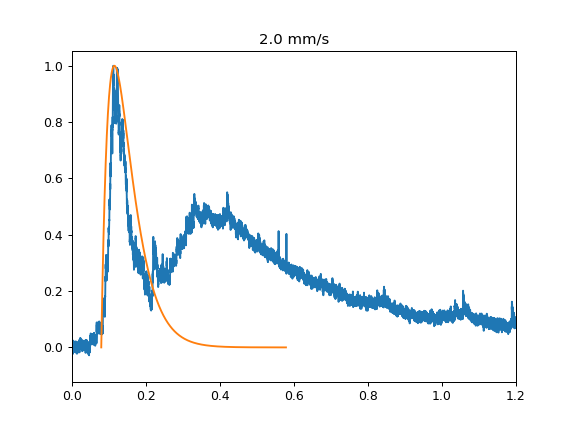

Text(0.5, 1.0, '2.0 mm/s')

In [16]:
start = nearest_index(ipsc_xaxes[2000], 0.6)
crop_ipsc_2000 = peak_normalize(np.mean(ipsc_recs[2000], axis=0)[start:], bsln_end=100)
crop_ipsc_2000_ax = np.arange(len(crop_ipsc_2000)) * (ipsc_xaxes[2000][1] - ipsc_xaxes[2000][0])

i2000_alpha_xaxis, i2000_alpha = make_biexp(500, 0.001, tau1=0.035, tau2=0.036)
i2000_fig, i2000_ax = plt.subplots(1)
i2000_ax.plot(crop_ipsc_2000_ax, crop_ipsc_2000)
i2000_ax.plot(i2000_alpha_xaxis + 0.08, i2000_alpha)
i2000_ax.set_xlim(0., 1.2)
i2000_ax.set_title("2.0 mm/s")

## TODO:
**Linear summation of bipolar and gaba inputs at different velocities**
- take this simple estimation of the gaba input, and "place" it a some x position, then sum that with bipolar inputs with delays modulated by velocity
- should the bipolar release rates be convolved into currents to be more directly comparable? Is recording somatic model current required for this stage?
- how detailed does this step really have to be?

In [17]:
quanta_h5 = "/mnt/Data/prerna_velocity/static_roi_waveforms/quantum_pack.h5"
with h5.File(quanta_h5, "r") as f:
    quantum_pack = unpack_hdf(f)
    
iglusnfr_quantum = quantum_pack["quantum"]
bp_inputs = quantum_pack["aligned_recs"]
release_rates = quantum_pack["clipped_rates"]
dd_rec = quantum_pack["aligned_recs"]["DD"]
pd_rec = quantum_pack["aligned_recs"]["PD"]
dd_rate = release_rates["DD"][500]["static_spot"]
pd_rate = release_rates["PD"][500]["static_spot"]
bp_dt = quantum_pack["rec_dt"]
model_dt = 0.001

In [18]:
ampa_alpha_xaxis, ampa_alpha = make_biexp(1500, model_dt, tau1=0.00014, tau2=0.00054)
vel_clip = velocity_rate(pd_rec, bp_dt, ampa_alpha, 0.1, spot=0.4)

rng = np.random.default_rng()
glu_rpq = poisson_of_release(rng, pd_rate)
glu_rpq_sum = sum_quanta(glu_rpq, np.arange(len(glu_rpq)) * bp_dt, iglusnfr_quantum, bp_dt)
glu_rpq_sum_xaxis = np.arange(len(glu_rpq_sum)) * bp_dt   
rpq = poisson_of_release(rng, vel_clip)
rpq_sum = sum_quanta(rpq, np.arange(len(rpq)) * model_dt, ampa_alpha, model_dt)
rpq_sum_xaxis = np.arange(len(rpq_sum)) * model_dt   

<IPython.core.display.Javascript object>


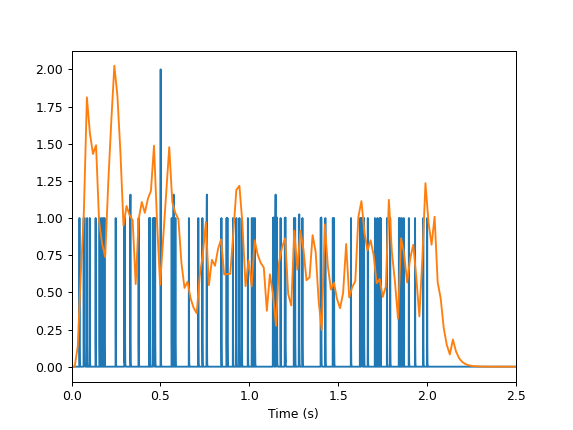

Text(0.5, 0, 'Time (s)')

In [19]:
ampa_vs_iglusnfr_fig, ampa_vs_iglusnfr_ax = plt.subplots(1)
ampa_vs_iglusnfr_ax.plot(rpq_sum_xaxis, rpq_sum)
ampa_vs_iglusnfr_ax.plot(glu_rpq_sum_xaxis, glu_rpq_sum)
ampa_vs_iglusnfr_ax.set_xlim(0, 2.5)
ampa_vs_iglusnfr_ax.set_xlabel("Time (s)")

<IPython.core.display.Javascript object>


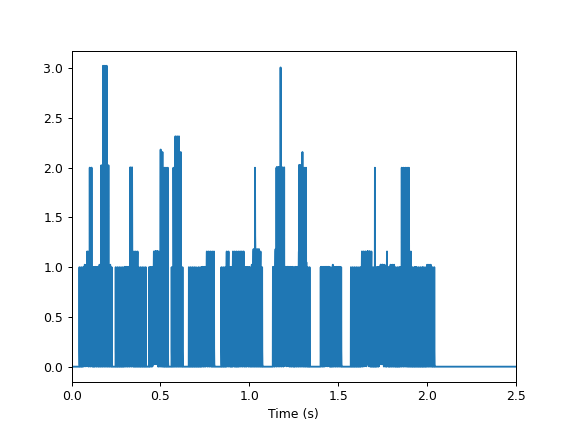

Text(0.5, 0, 'Time (s)')

In [20]:
temporal_sum_fig, temporal_sum_ax = plt.subplots(1)
staggered_sum = temporal_sum([(i * 0.01, rpq_sum) for i in range(5)], 5, model_dt)
temporal_sum_ax.plot(np.arange(len(staggered_sum)) * model_dt, staggered_sum)
temporal_sum_ax.set_xlim(0, 2.5)
temporal_sum_ax.set_xlabel("Time (s)")

### First pass for velocity "experiment": 
- inputs will be input waves for each velocity for sust/trans/gaba
  - `inputs = {"sust": {v: wave for v in velocities}, ...}`
- locations provided separately
  - `locs = {"sust": [...], ...}`

In [21]:
def run(velocities, syn_locs, syns, null=True, start_t=0.0, start_loc=150., dur=5.0, dt=model_dt):
    v_sign = -1 if null else 1.
    out = {}
    for v in velocities:
        inputs = []
        for k in syn_locs.keys():
            for loc in syn_locs[k]:
                t = (loc - start_loc) / v * v_sign
                if t < 0.0:
                    raise ValueError(
                        "Negative release time (consider start_loc and whether null)"
                    )
                inputs.append((start_t + t, syns[k][v]))
        out[v] = temporal_sum(inputs, dur, dt)
    return out

velocities = [100, 300, 500, 1000, 2000]
gaba_alphas = [i100_alpha, i300_alpha, i500_alpha, i1000_alpha, i2000_alpha]
locs = {
    "sust": [10, 20, 25, 30, 40, 50], 
    "trans": [20, 40, 50, 60, 70, 75, 80, 85, 90, 100, 110, 120],
    "gaba": [100],
}

def vel_bp_ampa(rec, bp_dt, alpha, vel, spot):
    rate = velocity_rate(rec, bp_dt, alpha, vel, spot=spot, model_dt=model_dt)
    rpq = poisson_of_release(rng, rate)
    return sum_quanta(rpq, np.arange(len(rpq)) * model_dt, alpha, model_dt)

syns = {
   "sust": {
       v: velocity_rate(pd_rec, bp_dt, ampa_alpha, v / 1000, spot=0.2)
#        v: vel_bp_ampa(pd_rec, bp_dt, ampa_alpha, v / 1000, spot=0.4)
       for v in velocities
   }, 
   "trans": {
       v: velocity_rate(dd_rec, bp_dt, ampa_alpha, v / 1000, spot=0.2)
#        v: vel_bp_ampa(dd_rec, bp_dt, ampa_alpha, v / 1000, spot=0.4)
       for v in velocities
   },
    "gaba": {v: a * -1.5 for v, a in zip(velocities, gaba_alphas)},
}

<IPython.core.display.Javascript object>


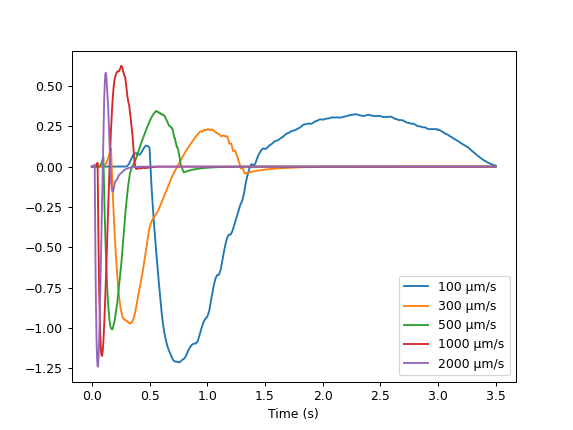

Text(0.5, 0, 'Time (s)')

In [22]:
dur = 3.5
bp_gaba_sum = run(velocities, locs, syns, dur=dur, dt=model_dt, start_loc=150)
bp_gaba_sum_xaxis = np.arange(int(dur / model_dt)) * model_dt

bp_gaba_sum_fig, bp_gaba_sum_ax = plt.subplots(1)
for v, r in bp_gaba_sum.items():
    bp_gaba_sum_ax.plot(bp_gaba_sum_xaxis, r, label="%i µm/s" % v)
    
bp_gaba_sum_ax.legend()
bp_gaba_sum_ax.set_xlabel("Time (s)")

<IPython.core.display.Javascript object>


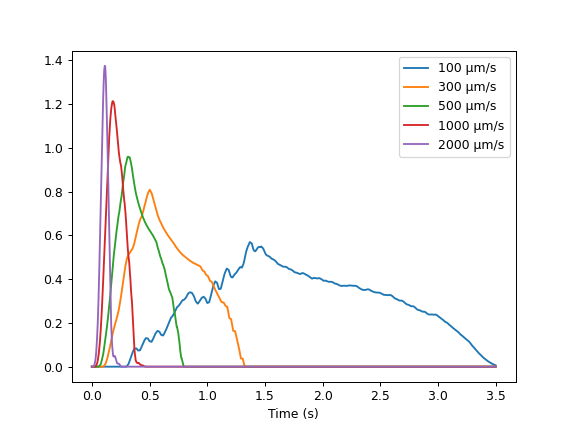

Text(0.5, 0, 'Time (s)')

In [23]:
dur = 3.5
no_gaba_locs = {k: v for k, v in locs.items() if k != "gaba"}
bp_only_sum = run(velocities, no_gaba_locs, syns, dur=dur, dt=model_dt, start_loc=150)
bp_only_sum_xaxis = np.arange(int(dur / model_dt)) * model_dt

bp_only_sum_fig, bp_only_sum_ax = plt.subplots(1)
for v, r in bp_only_sum.items():
    bp_only_sum_ax.plot(bp_only_sum_xaxis, r, label="%i µm/s" % v)
    
bp_only_sum_ax.legend()
bp_only_sum_ax.set_xlabel("Time (s)")

<IPython.core.display.Javascript object>


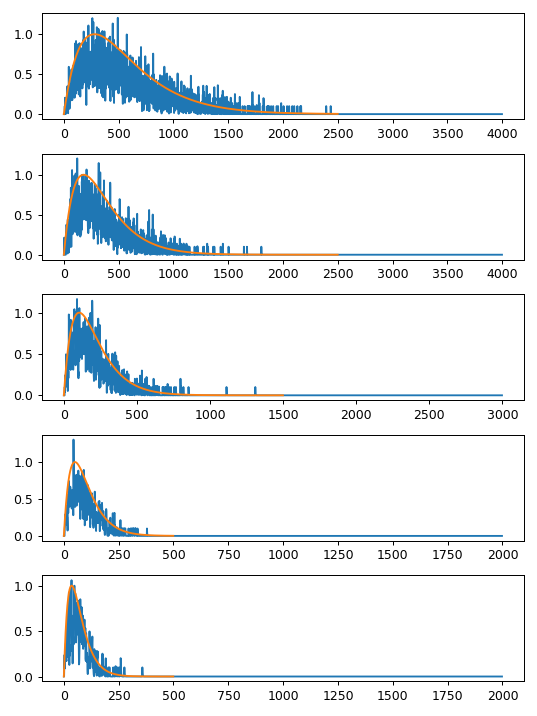

In [29]:
gaba_mini_alpha_xaxis, gaba_mini_alpha = make_biexp(
    1500, model_dt, tau1=0.0002, tau2=0.001)

gaba_alpha_vels = {v: a for v, a in zip(velocities, gaba_alphas)}

gaba_quanta = {
    v: poisson_of_release(rng, a * 4)
    for v, a in zip(velocities, gaba_alphas)
}

gaba_quanta_sum = {
    v: sum_quanta(q, np.arange(len(q)) * model_dt, gaba_mini_alpha * 0.1, model_dt)
    for v, q in gaba_quanta.items()
}

gaba_quanta_fig, gaba_quanta_ax = plt.subplots(len(velocities), figsize=(6, 8))
for ax, v in zip(gaba_quanta_ax, velocities):
    ax.plot(gaba_quanta_sum[v])
    ax.plot(gaba_alpha_vels[v])
    
gaba_quanta_fig.tight_layout()
# glu_rpq = poisson_of_release(rng, pd_rate)
# glu_rpq_sum = sum_quanta(glu_rpq, np.arange(len(glu_rpq)) * bp_dt, iglusnfr_quantum, bp_dt)
# glu_rpq_sum_xaxis = np.arange(len(glu_rpq_sum)) * bp_dt   
# rpq = poisson_of_release(rng, vel_clip)
# rpq_sum = sum_quanta(rpq, np.arange(len(rpq)) * model_dt, ampa_alpha, model_dt)
# rpq_sum_xaxis = np.arange(len(rpq_sum)) * model_dt   